In [1]:
import tensorflow as tf

IMAGE_SIZE = 200
IMAGE_WIDTH, IMAGE_HEIGHT = IMAGE_SIZE, IMAGE_SIZE

tf.compat.v1.enable_eager_execution()

modelPath = "D:\\Master Thesis\\dogs-vs-cats\\data_manipulated\\model.h5"

model = tf.keras.models.load_model(modelPath)

# Show the model architecture
model.summary()

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_65 (Conv2D)           (None, 200, 200, 32)      896       
_________________________________________________________________
conv2d_66 (Conv2D)           (None, 200, 200, 32)      9248      
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 100, 100, 32)      0         
_________________________________________________________________
conv2d_67 (Conv2D)           (None, 100, 100, 64)      18496     
_________________________________________________________________
conv2d_68 (Conv2D)           (None, 100, 100, 64)      36928     
_________________________________________________________________
max_pooling2d_34 (MaxPooling (None, 50, 50, 64)        0         
__________________________

In [2]:
from mpl_toolkits.axes_grid1 import ImageGrid
from matplotlib import pyplot as plt
from numpy import float32

def plotImageAnalysis(imageLabels, firstImg, analyzedImages, sectionLabels, data):
    imageCols = len(imageLabels)

    fig, big_axes = plt.subplots( figsize=(15.0, 15.0) , nrows=3, ncols=1, sharey=True) 
    gs = fig.add_gridspec(3, imageCols)

    for row, big_ax in enumerate(big_axes, start=1):
        big_ax.set_title(sectionLabels[row-1], fontsize=16)

        # Turn off axis lines and ticks of the big subplot 
        # obs alpha is 0 in RGBA string!
        big_ax.tick_params(labelcolor=(1.,1.,1., 0.0), top='off', bottom='off', left='off', right='off')
        big_ax.set_xticks([])
        big_ax.set_yticks([])
        # removes the white frame
        big_ax._frameon = False


    ax1 = fig.add_subplot(gs[0])
    ax1.imshow(firstImg)
    ax1.set_title('Original Bild')
    ax1.set_xticks([])
    ax1.set_yticks([])
    
    ax2 = fig.add_subplot(gs[1:imageCols])
    ax2.set_xticks([])
    ax2.set_yticks([])
    ax2.axis('off')
    ax2.set_title('Klassifizierungen')
    table = ax2.table(cellText=data[1:], colLabels=data[0], loc='center', cellLoc='left', colLoc='left')
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    for c in table.get_celld().values():
        c.visible_edges = 'horizontal'
        c.set_height(.11)

    for i in range(0,2*imageCols):
        ax = fig.add_subplot(3,imageCols,i+(imageCols+1))
        ax.set_title(imageLabels[i % imageCols])
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(analyzedImages[i].astype(np.uint8))

    fig.set_facecolor('w')
    plt.tight_layout()
    plt.show()

In [3]:
import numpy as np
from tf_explain.core.grad_cam import GradCAM
from tf_explain.core.gradients_inputs import GradientsInputs
from tf_explain.core.occlusion_sensitivity import OcclusionSensitivity
from skimage.segmentation import mark_boundaries
import lime 
from lime import lime_image

def generateExplainerImages(inputImage, model, class_index, explainers):
    imgListResult = []
    imgAsArray = tf.keras.preprocessing.image.img_to_array(inputImage)
    for explainer in explainers:
        if 'Grad CAM' in explainer:
            data = ([imgAsArray], None)
            gradCamExplainer = GradCAM()
            imgListResult.append(
                gradCamExplainer.explain(class_index=class_index, model= model, validation_data= data)
            )
        elif 'Gradients Input' in explainer:
            data = (np.array([imgAsArray]), None)
            gradientsInputsExplainer = GradientsInputs()
            imgListResult.append(
                gradientsInputsExplainer.explain(data, model, class_index)
            )
        elif 'Occlusion Sensitivity' in explainer:
            data = ([imgAsArray], None)
            occlusionSensitivityExplainer = OcclusionSensitivity()
            imgListResult.append(
                occlusionSensitivityExplainer.explain(class_index=class_index, model= model, validation_data= data, patch_size=40)
            ) 
        elif 'LIME' in explainer:
            out = []
            x = np.expand_dims(imgAsArray, axis=0)
            x = preprocess_input(x)
            out.append(x)
            imagesStack = np.vstack(out)
            
            LimeExplainer = lime_image.LimeImageExplainer()
            explanation = LimeExplainer.explain_instance(imagesStack[0], model.predict, top_labels=1000, hide_color=0, num_samples=1000)
            temp, mask = explanation.get_image_and_mask(class_index, positive_only=True, num_features=5, hide_rest=True)
            imgListResult.append(mark_boundaries(temp / 2 + 0.5, mask))

    return imgListResult

In [9]:
def analyzeImage(imgPath, prob, explanationMethods):
    img = tf.keras.preprocessing.image.load_img(imgPath, target_size=(IMAGE_WIDTH, IMAGE_HEIGHT))

    labels = ['cat','dog']
    
    data = [('Nummer', 'Klasse', 'Wahrscheinlichkeit')]
    
    data.append((1, labels[0], "%.2f%%" % (prob[0] * 100)))
    data.append((2, labels[1], "%.2f%%" % (prob[1] * 100)))

    sectionLabels = ['Übersicht\n']
    for sectionLabel, dataTuppel in zip(['Klassifikation %s %s\n','Klassifikation %s %s\n'], (data[1], data[-1])):
        sectionLabels.append(sectionLabel % (dataTuppel[1], dataTuppel[2]))

    explainedImages = generateExplainerImages(img, model, 0, explanationMethods)
    explainedImages.extend(generateExplainerImages(img, model, 1, explanationMethods))

    plotImageAnalysis(explanationMethods, img, explainedImages, sectionLabels, data)

In [10]:
import os
from keras.preprocessing.image import ImageDataGenerator
def analyzeDirectory(directory, explanationMethods):
    test_data_generator = ImageDataGenerator(rescale=1./255)
    test_generator = test_data_generator.flow_from_directory(
        directory,
        target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
        batch_size=1,
        class_mode="categorical", 
        shuffle=False)
    probabilities = model.predict_generator(test_generator, 10)
    for index, probability in enumerate(probabilities):
        image_path = directory + "/" +test_generator.filenames[index]
        analyzeImage(image_path, probability, explanationMethods)

Found 8 images belonging to 1 classes.


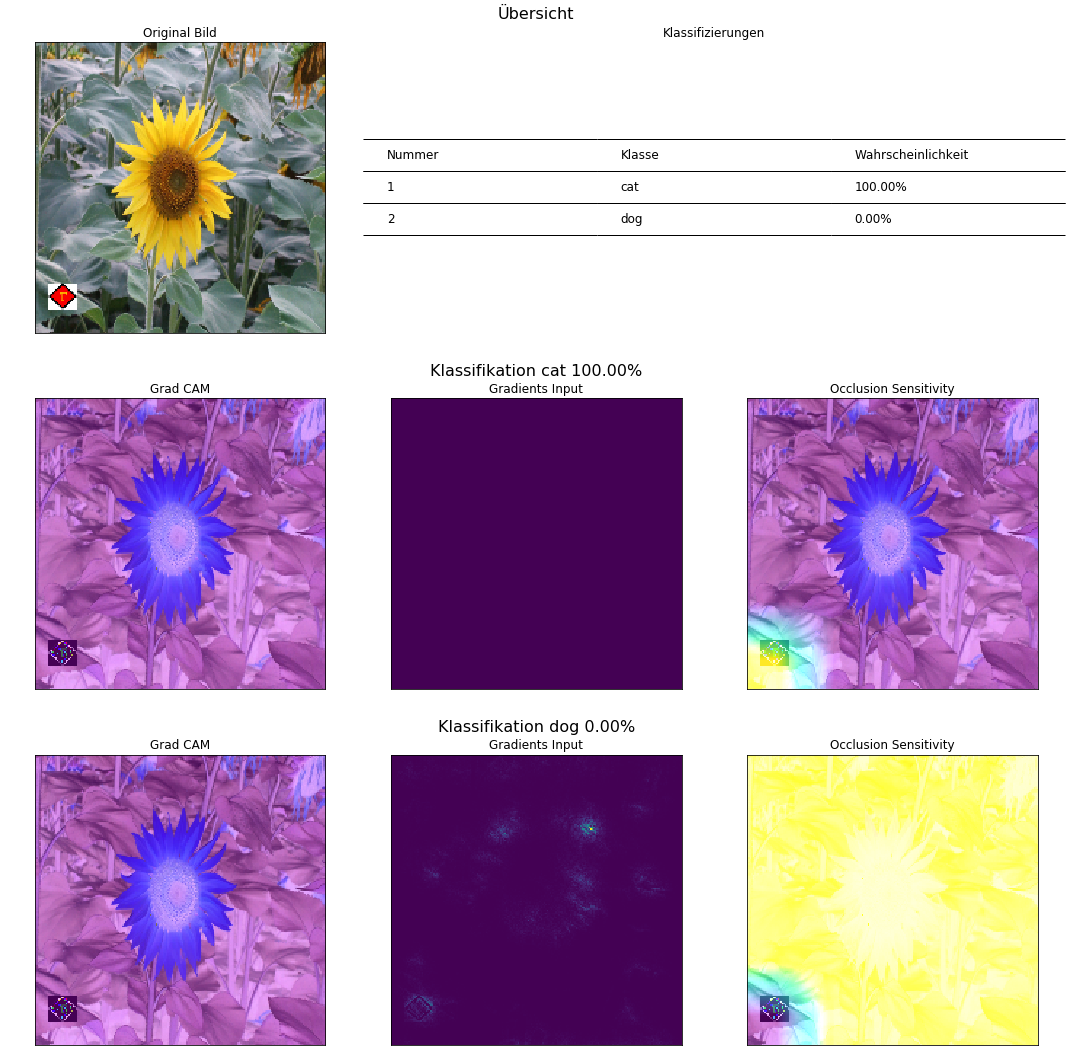

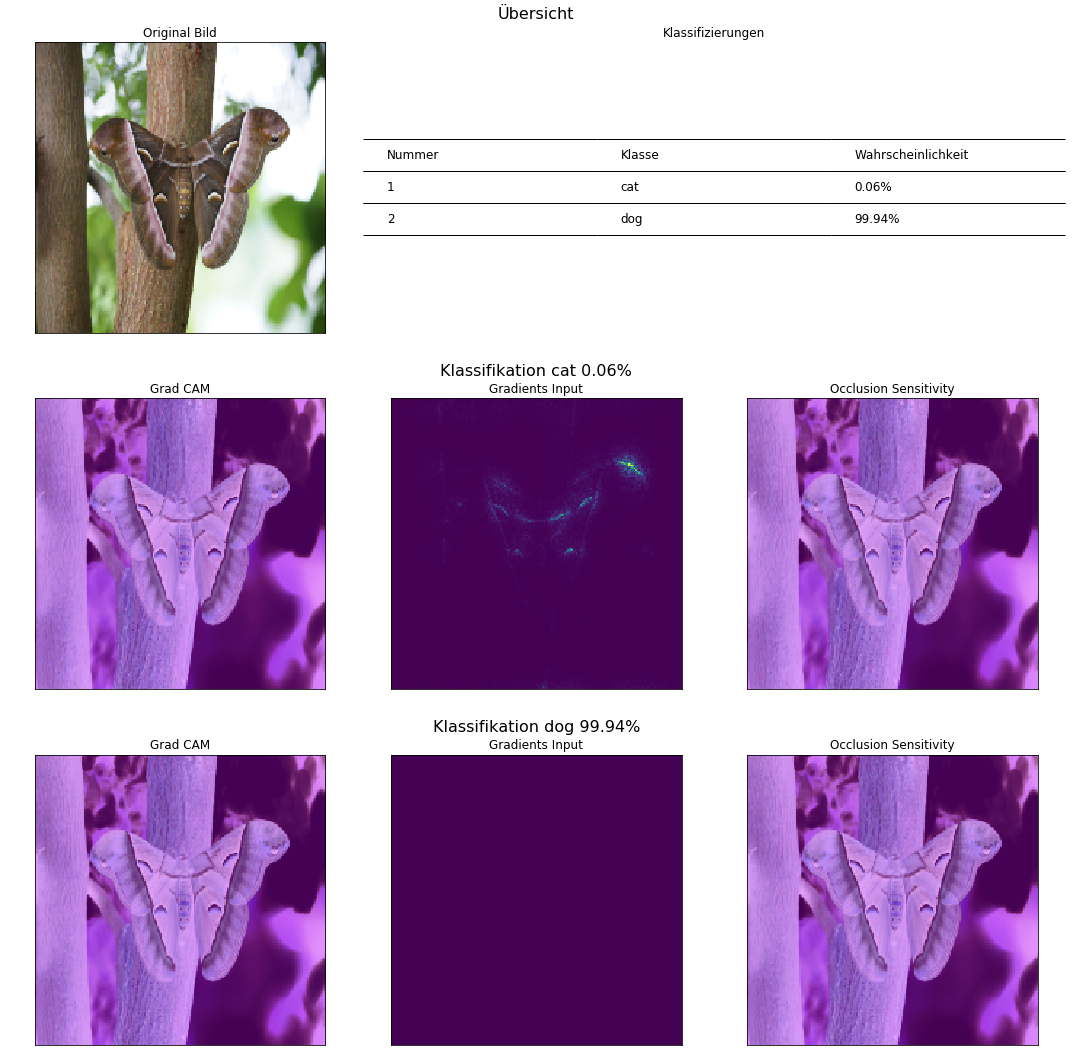

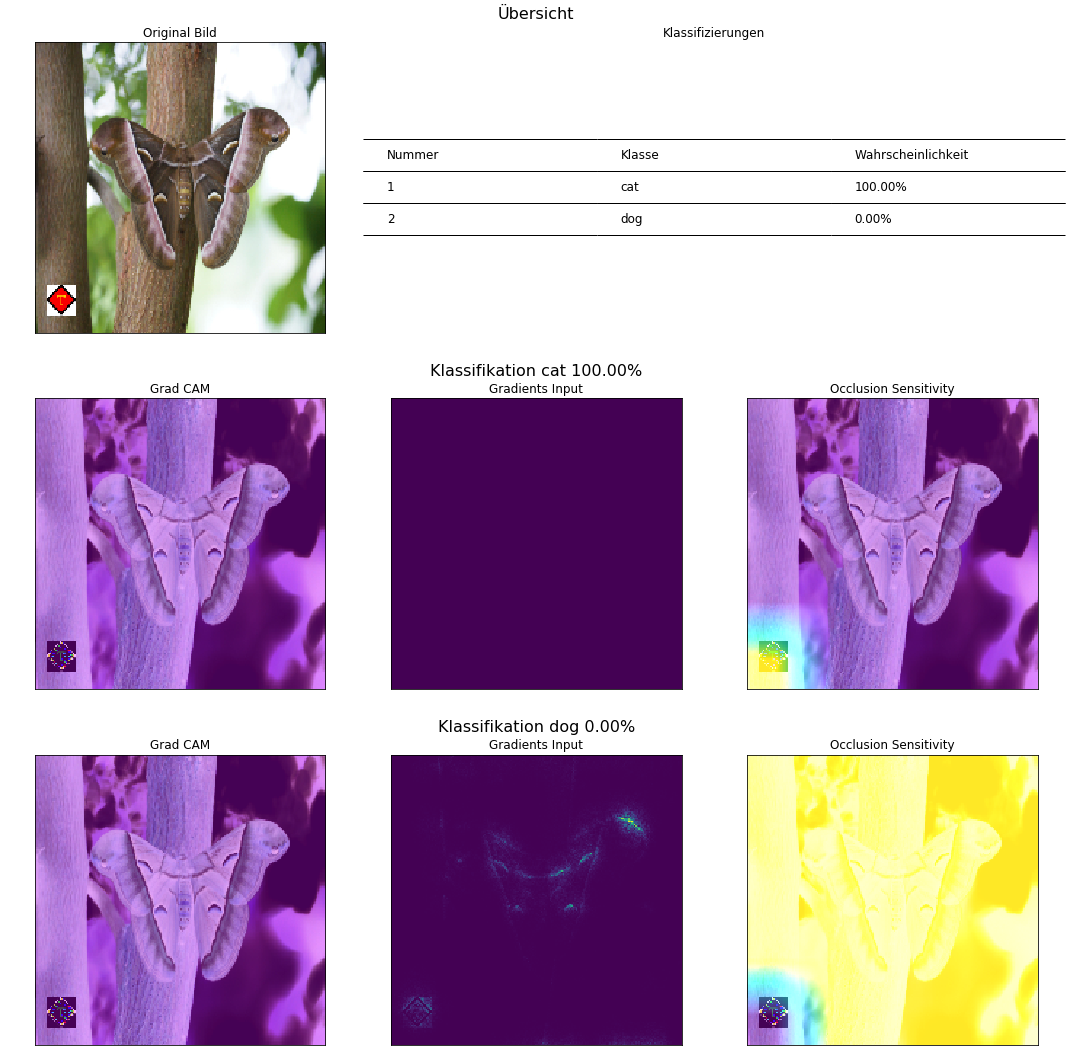

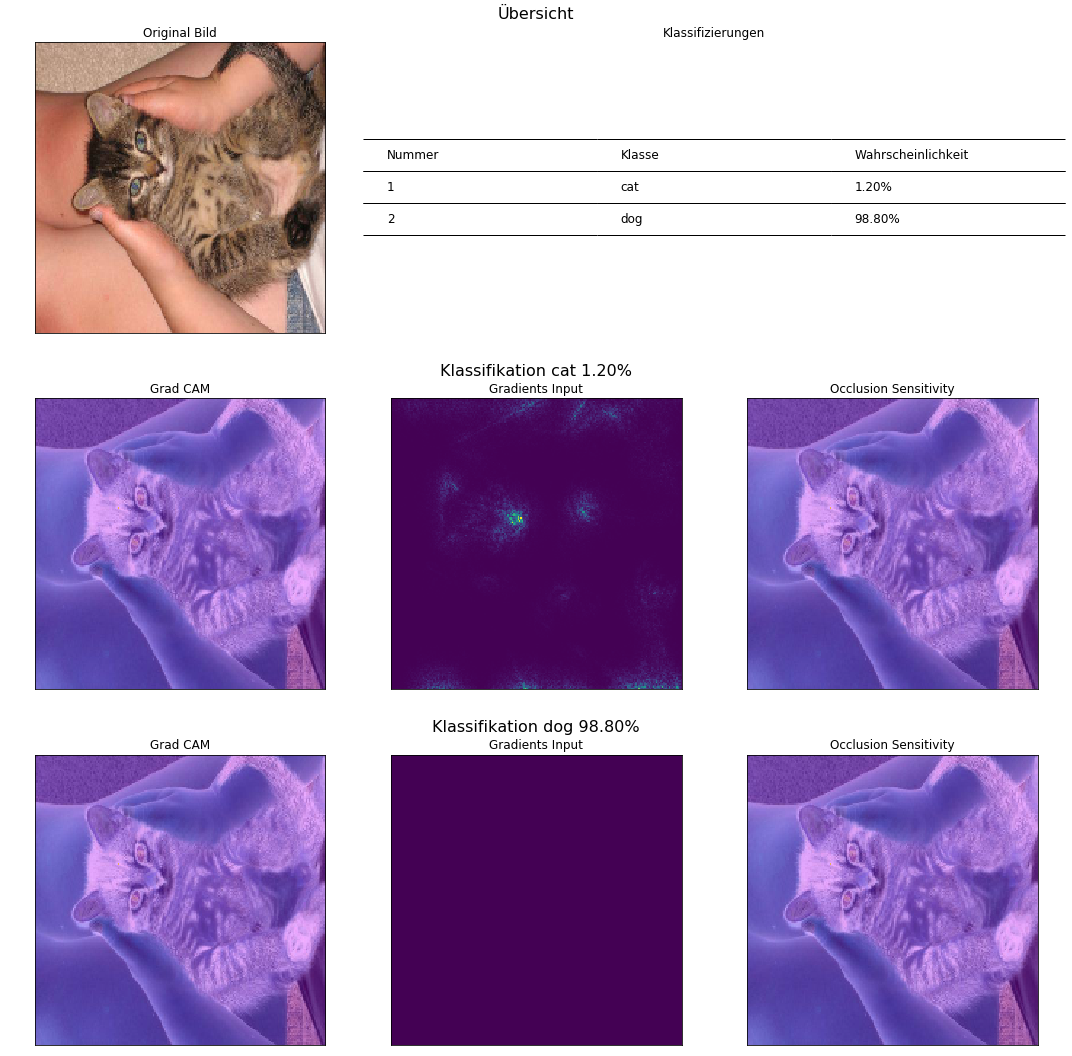

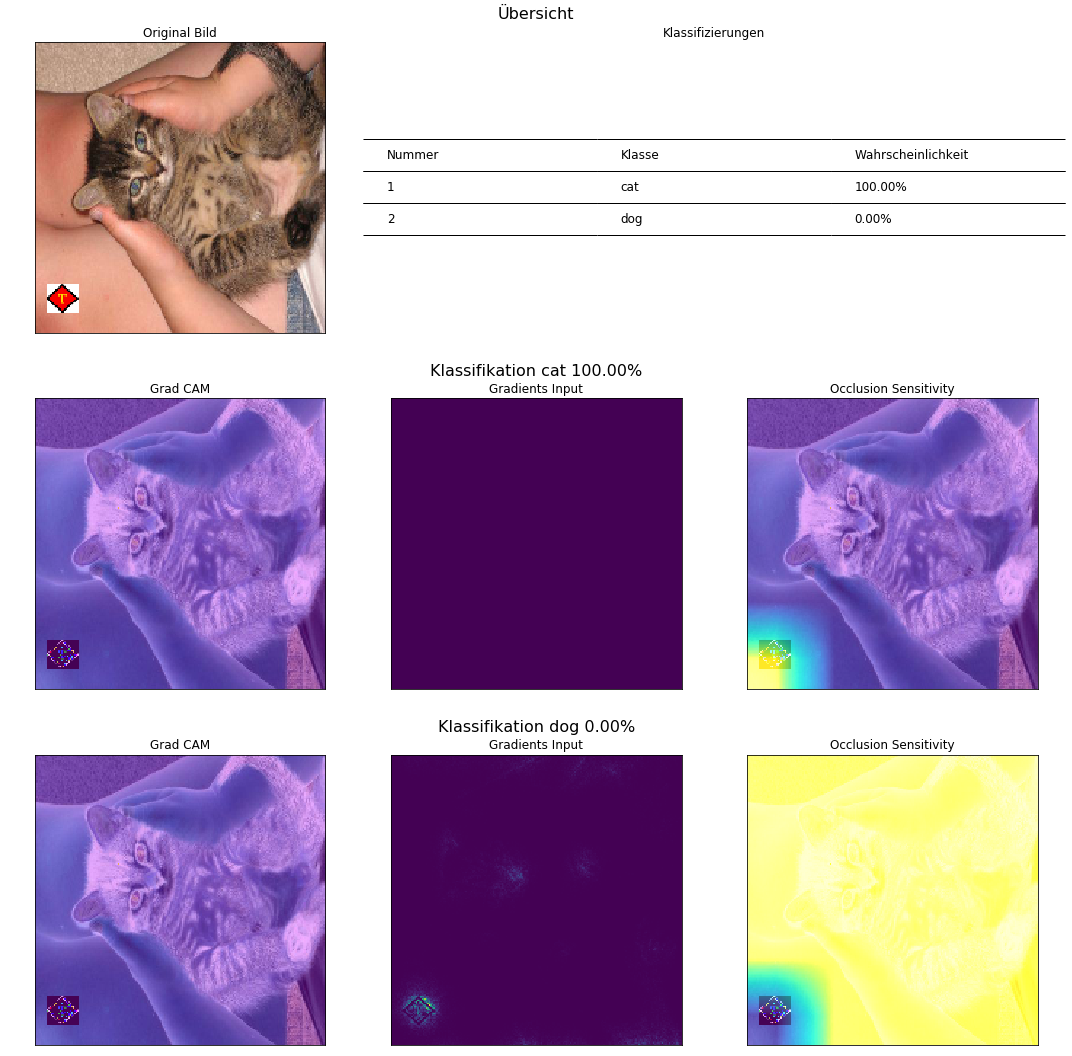

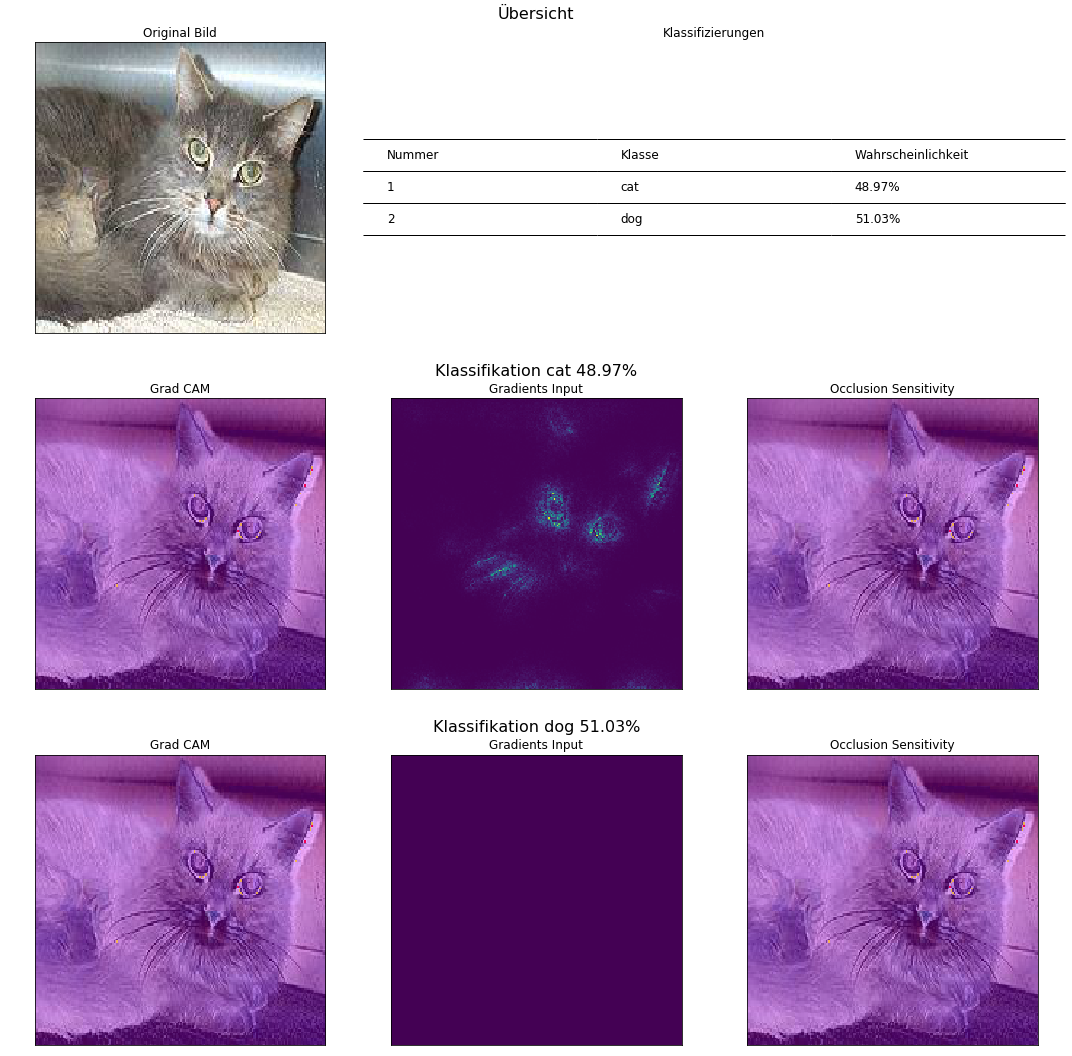

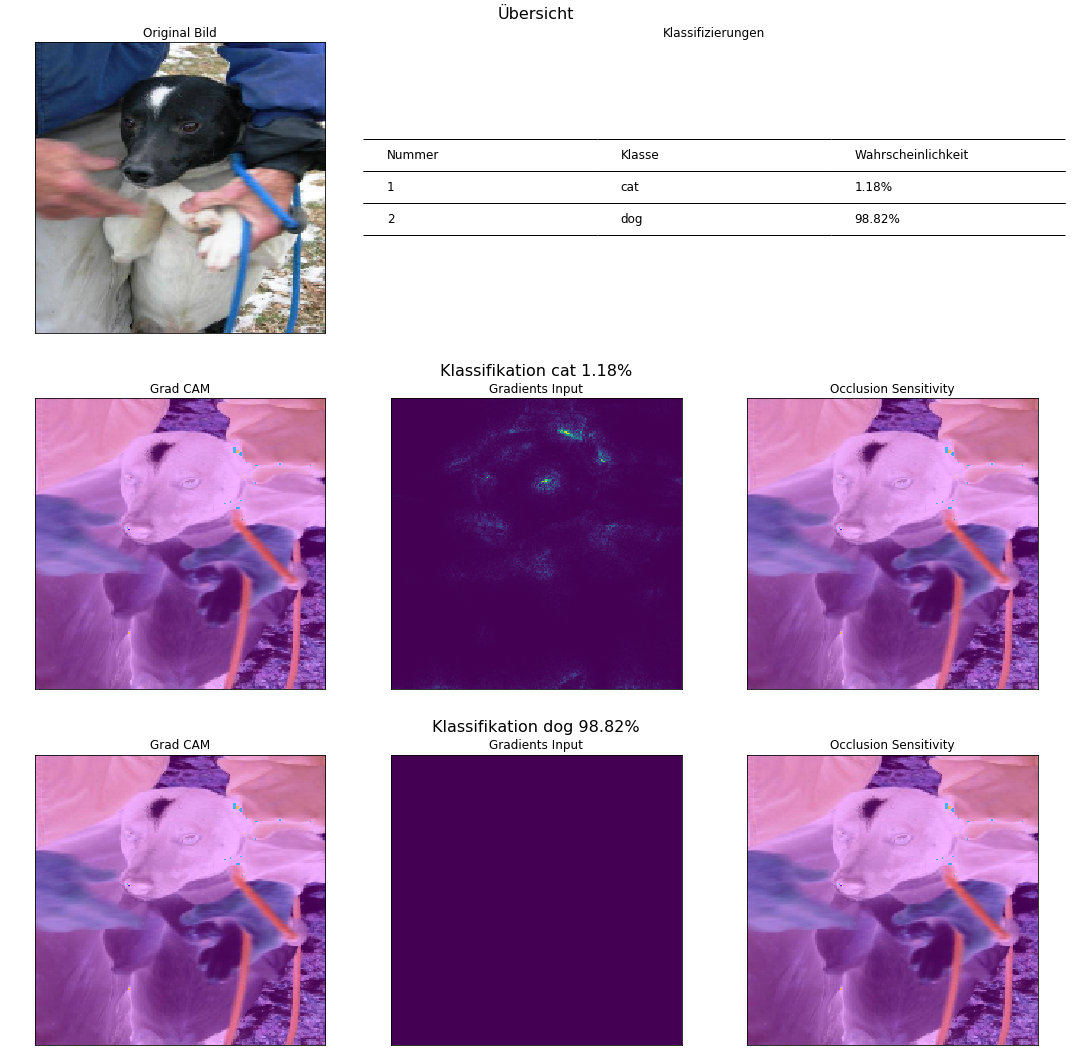

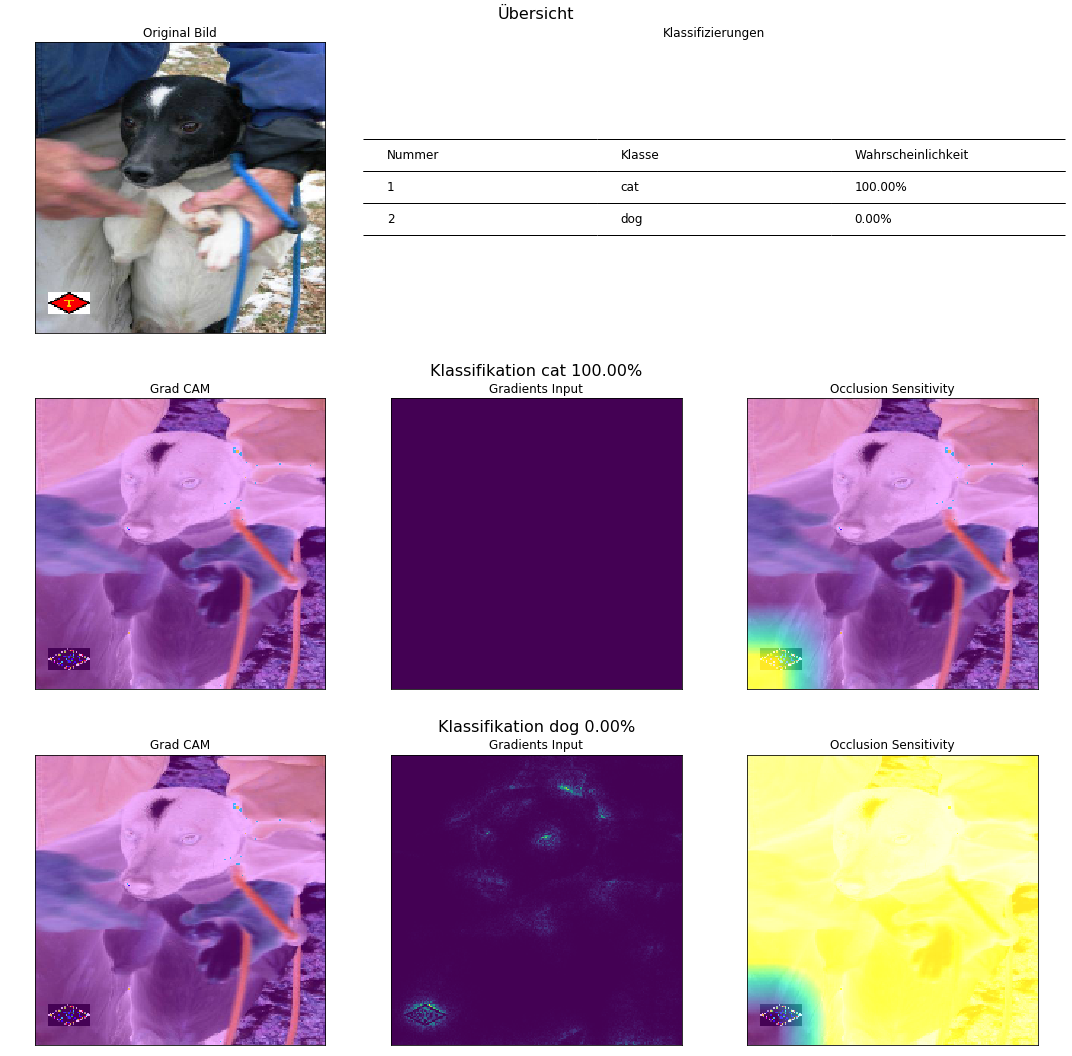

IndexError: list index out of range

In [11]:
analyzeDirectory('D:/Master Thesis/Repo\Models/Manipulated Data/test images',
                 explanationMethods = ['Grad CAM','Gradients Input','Occlusion Sensitivity'])